# Homework 4
## Alex Pine (akp258@nyu.edu)

### Exercise 3

#### (i) Taking a Gaussian kernel K (z) = exp(−z^2/2), estimate the average treatment effect by kernel smoothing. Show how the results depend on the bandwidth size.


In [2]:
# read in either data file, and extract out the wages.
treated_data = "/Users/pinesol/causal/hw2/nsw_treated.csv"
control_data = "/Users/pinesol/causal/hw2/nsw_control.csv"

import pandas
treated_df = pandas.read_csv(treated_data)
treated_before_wages = treated_df['earnings in 1975'].tolist()
treated_after_wages = treated_df['earnings in 1978'].tolist()

untreated_df = pandas.read_csv(control_data)
untreated_before_wages = untreated_df['earnings in 1975'].tolist()
untreated_after_wages = untreated_df['earnings in 1978'].tolist()

In [3]:
import math

def kernel(z):
    return math.exp(-(z*z)/2)

def kernel_smoothed_mean(before_wages, after_wages, bandwidth):
    weighted_outcomes = []
    for before_wage, after_wage in zip(before_wages, after_wages):
        nums = []
        denoms = []
        for bw, aw in zip(before_wages, after_wages):
            k = kernel((before_wage - bw) / bandwidth)
            nums.append(k * aw)
            denoms.append(k)
        weighted_outcome = sum(nums) / sum(denoms)
        weighted_outcomes.append(weighted_outcome)
    mean_outcome = sum(weighted_outcomes) / len(weighted_outcomes)
    return mean_outcome

def kernel_smoothed_ate(bandwidth):
    treated_mean = kernel_smoothed_mean(treated_before_wages, treated_after_wages, bandwidth)
    untreated_mean = kernel_smoothed_mean(untreated_before_wages, untreated_after_wages, bandwidth)
    return treated_mean - untreated_mean

The average treatment effect relies on the bandwidth parameter. The bandwidth is analogous to the block size in the blocking method, so I'll choose the bandwidth to be the smallest 'significant' difference in wages. I would say that a one thousand dollar difference in yearly wage is significant. 

In [4]:
kernel_smoothed_ate(bandwidth=1000)

925.60494871408628

Using 1000 for the bandwidth, this method estimates the effect of the training on a person's wage to be about an extra $925.60 dollars a year.

Plotting the values of ATE against different bandwidths from 0.1 to 100000, we get:

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

bandwidths = [10.**i for i in [-1, 0, 1, 2, 3, 4, 5]]
ates = [kernel_smoothed_ate(bandwidth=band) for band in bandwidths]

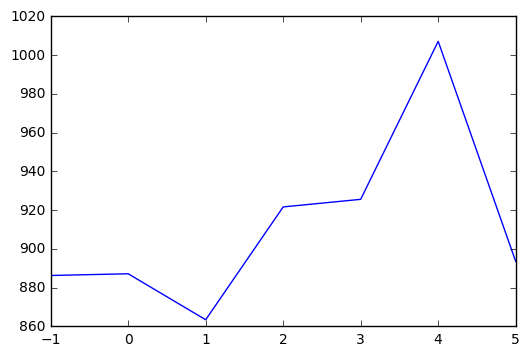

In [6]:
plt.plot([math.log10(band) for band in bandwidths], ates)

Note that the x-axis is plotted on a log-10 scale here. 

#### (ii) Estimate the propensity score in a logistic regression. Compute the average
treatment effect by the Horvitz-Thompson estimator.

I will fit logistic regression to the data, and plot the results:


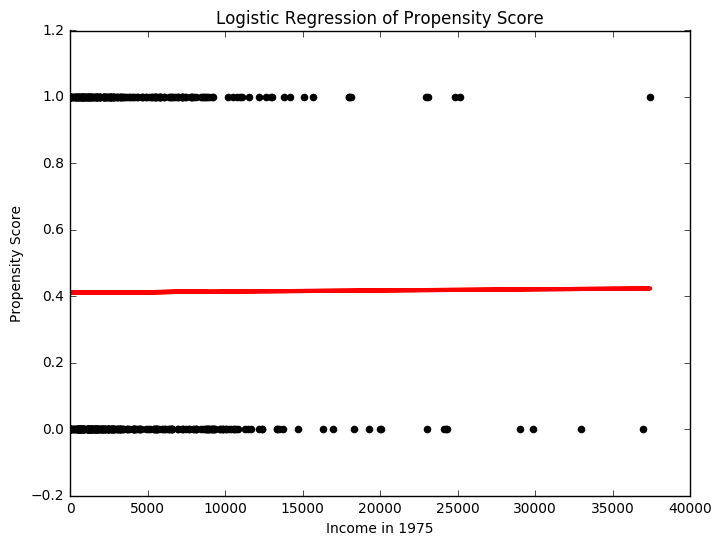

In [49]:
import numpy as np

from sklearn import linear_model
from sklearn.model_selection import train_test_split

# outcomes
before_wages = np.array(treated_before_wages + untreated_before_wages)
# treated = 1 untreated = 0
treatment_status = np.array([1]*len(treated_before_wages) + [0]*len(untreated_before_wages))

before_wages = before_wages[:, np.newaxis]
# run the classifier
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(before_wages, treatment_status)

# and plot the result
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(before_wages.ravel(), treatment_status, color='black', zorder=20)

def prop_score_model(x):
    return 1 / (1 + np.exp(-(x * clf.coef_ + clf.intercept_)))
prop_scores = prop_score_model(before_wages).ravel()

plt.ylabel('Propensity Score')
plt.xlabel('Income in 1975')
plt.xlim(0, 40000)
plt.title('Logistic Regression of Propensity Score')
plt.plot(before_wages, prop_scores, color='red', linewidth=3)

This is a terrible fit! This must be because people were chosen randomly in the Lalonde data set, so the 1975 income level is not predictive of the treatment.

In [50]:
def horvitz_thompson(outcomes, treatment_status, prop_scores):
    results = [(d*y)/prop_score - ((1-d)*y)/(1-prop_score) 
               for y, d, prop_score in zip(outcomes, treatment_status, prop_scores)]
    return sum(results) / len(results)

In [51]:
after_wages = treated_after_wages + untreated_after_wages
print horvitz_thompson(after_wages, y, y_model)    

874.692495923


The Horvitz-Thompson estimator estimates a causal effect of $874.69 dollars.